### Remerge Data Science Challenge
#### Sam Clampitt, 12.3.2019

In [1]:
import pandas as pd
import numpy as np
import os
import json
from classModelEval import modelFitEval
from matplotlib import pyplot as plt
import seaborn as sns

In [10]:
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Structure

        * Feature engineering
            * Processing with categorical features with many levels into a dense feature vector
            
        * Training procedure
            
        * Model evaluation
            * Histograms of Probability Estimates
            * Confusion Matrices and Multi-Metric Evaluation
            * Training Curve
            
        * Further steps


In [2]:
#Navigate to the location of the extracted CSVs and read their filenames into a list 
os.chdir('separate_all_raw')
list_of_csv_filenames = os.listdir()
df_first_day = pd.read_csv(list_of_csv_filenames[0])

## Feature Engineering

### The dataset contains almost strictly categorical features. A typical approach would be to use one-hot encoding, but here this would produce a large and unwieldy, sparse feature vector.

### From the following columns, I computed a dense feature vector using aggregate functions:

In [3]:
categorical_columns = ['device_type', 
                       'os', 
                       'os_version',
                       'partner', 
                       'publisher_app', 
                       'organization', 
                       'audience', 
                       'campaign', 
                       'ad_type', 
                       'ad_size', 
                       'country']

In [5]:
total_levels_categorical_features = np.sum([len(df_first_day[categorical_column].unique()) for categorical_column in categorical_columns])
print("A one-hot encoded feature vector for the records in %s would have a length of %d" % (list_of_csv_filenames[0], total_levels_categorical_features))

A one-hot encoded feature vector for the records in data_20180601.csv would have a length of 20237


### Rather than using > 20,000 binary features, I engineer a much shorter, dense vector with features that enjoy a strong correlation with the target 'conversions'. 

### Because there are likely a different number of levels for each categorical feature in each day of the data, and each day has around $10^6$ rows, this may be more practical.

### I wrote several functions which, for each level of each categorical column, compute cumulative aggregate features.

#### This is how the processed dataframe looks at the beginning, though this first day is excluded from the training data.

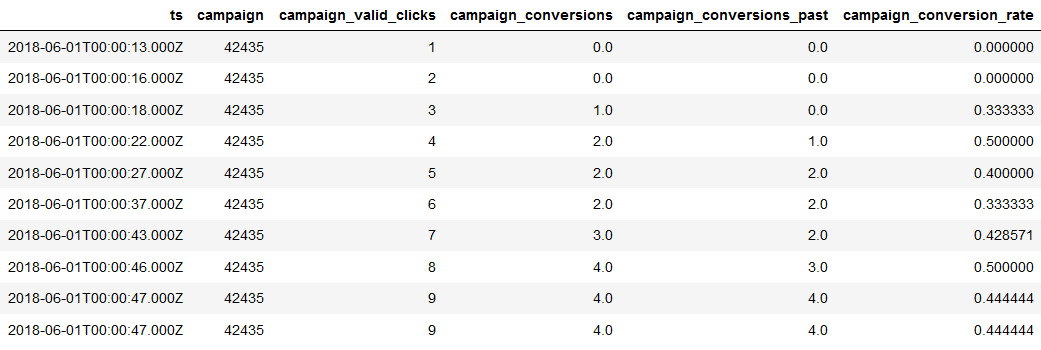

In [19]:
os.chdir('..')
Image(filename = "campaign_42435.png", width=1000, height=1000)

### I parse the clicks and conversions in such a way to enable the computation of two very useful features for each campaign, audience, publisher, country, etc.: 

    1. The rate of conversions
    2. The rate of invalid clicks
    
#### I consider each record as a 'click'. A record where 'clicks' == 1 is a 'valid_click'. A record where 'click_event' == 'click' but 'clicks' is null is an 'invalid_click'. A record where 'conversions' == 1 is a 'conversion'.
#### By encoding clicks, valid clicks, and conversions as binary features, I can compute a feature for the rate of invalid clicks / clicks and a feature for the rate of conversions / clicks for each level of each of the categorical features. Possibly as a nice bonus, these features are essentially metrics for each of the individual campaigns, audiences, countries, etc. 
### Some of these features (in particular, the conversion and invalid click rates  for 'campaign', 'audience', and 'organization') enjoy a strong linear correlation with the target 'conversions'. 

#### For 'conversion_rate', the correlation is positive. For 'invalid_click_rate', the correlation is negative.

In [29]:
df_processed_day= pd.read_csv('separate_all_raw/processed_csv/processed_data_20180602.csv').drop('valid_clicks', axis=1)

In [30]:
df_processed_day.corr()['conversions'].sort_values()

organization_invalid_click_rate_past    -0.480949
audience_invalid_click_rate_past        -0.461391
campaign_invalid_click_rate_past        -0.458431
country_invalid_click_rate_past         -0.310366
ad_type_invalid_click_rate_past         -0.244147
ad_size_invalid_click_rate_past         -0.239759
publisher_app_invalid_click_rate_past   -0.221210
partner_invalid_click_rate_past         -0.121734
device_type_invalid_click_rate_past     -0.001950
os_invalid_click_rate_past              -0.000291
os_conversion_rate_past                 -0.000114
device_type_conversion_rate_past         0.005185
partner_conversion_rate_past             0.252815
ad_type_conversion_rate_past             0.267020
ad_size_conversion_rate_past             0.272966
country_conversion_rate_past             0.417431
publisher_app_conversion_rate_past       0.487325
organization_conversion_rate_past        0.658596
audience_conversion_rate_past            0.667575
campaign_conversion_rate_past            0.709558


### At prediction time, we won't have the same cumulative features that I have computed. For this reason, I shift each feature forward by one record (grouped by each categorical column, with the timestamp as the index) to compute the 'past' values, those that would have existed at the time the click event took place i.e. as they would be at prediction time.

### These shifted 'past' values are the features that I use to train the model. After processing each CSV, I save the most recent values for the cumulative count columns to pass to the next iteration and begin where the previous one left off.

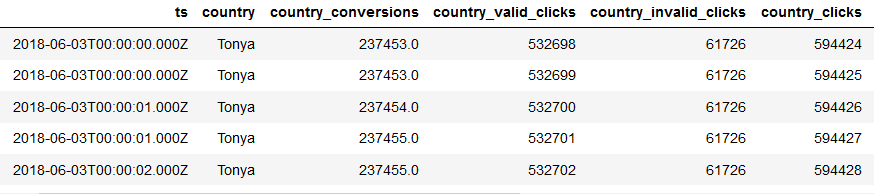

In [26]:
Image(filename = "country_tonya.png", width=1000, height=1000)

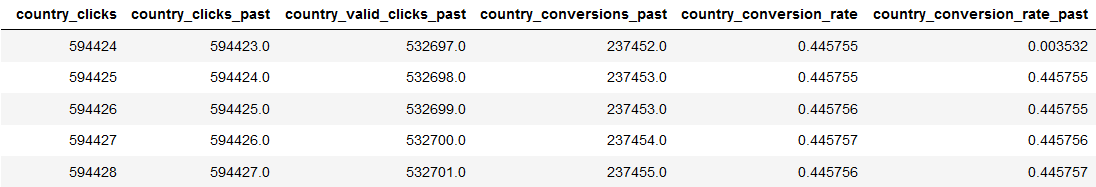

In [24]:
Image(filename = "country_tonya_shifted.png", width=1000, height=1000)

### Using only these valid 'past' features that will be available at prediction time -- the conversion and invalid click rates of each record's campaign, organization, publisher, etc. -- the input vector consists of only 20 features!

In [31]:
print(df_processed_day.shape)
list(df_processed_day)

(1323270, 21)


['device_type_conversion_rate_past',
 'device_type_invalid_click_rate_past',
 'os_conversion_rate_past',
 'os_invalid_click_rate_past',
 'partner_conversion_rate_past',
 'partner_invalid_click_rate_past',
 'publisher_app_conversion_rate_past',
 'publisher_app_invalid_click_rate_past',
 'organization_conversion_rate_past',
 'organization_invalid_click_rate_past',
 'audience_conversion_rate_past',
 'audience_invalid_click_rate_past',
 'campaign_conversion_rate_past',
 'campaign_invalid_click_rate_past',
 'ad_type_conversion_rate_past',
 'ad_type_invalid_click_rate_past',
 'ad_size_conversion_rate_past',
 'ad_size_invalid_click_rate_past',
 'country_conversion_rate_past',
 'country_invalid_click_rate_past',
 'conversions']

### Training procedure

#### For each CSV (sorted in ascending chronological order):

    * Compute the binary 'click', 'valid_click', and 'conversion' features
    
    * Compute the cumulative aggregates for each level of each categorical feature
        * Count of clicks, valid_clicks, and conversions
        * Rate of invalid_clicks and conversions
    
    * Save the final values of the present dataframe for each level of each categorical feature in a dictionary that will be passed to the next iteration to start the cumulative counts from where they left off
    
    * Drop all but the target feature and the 20 cumulative aggregate features that will be used for prediction and remove all invalid click events
    
    * For a day that will be used as training data:
        * Separate the conversion events from click events
        * Take a random sample of the click events equal in size to the conversion events to balance the classes 
        * Combine these two balanced subsets to one dataframe
        * Fit the classifiers to the cleaned data with engineered features
        
    * For a day that will be used as testing data:
        * Use the fitted models to predict, and save the ground truth values and predictions in a dictionary
#### I actually did this in two discrete steps: first processing the data and saving each day to disk as a CSV; then iterating over the  CSVs with engineered features, training the models on each day of data, and saving their predictions on subsequent days of data as a JSON to evaluate later.

### For each day of training, I used *subsequent and previously unseen* days as the test data. When the models had been fit to fewer than 5 days, I predicted only on the next day ahead. With 5 to 10 days, I predicted on the next 2 days. With more than 10 days, I predicted on the next 3 days. 

### Evaluation

#### Some time ago I wrote a module (classModelEval) for evaluating classification models, and used it here to generate the model metrics. It takes as input the ground truth values and predictions, and has numerous methods returning multi-metric evaluation of the prediction quality (accuracy, confusion matrix, $F_1$, precision and recall scores, etc.)

Evaluation, training days: 1, predicting days 1


Linear classifier accuracy: 85.34%


,Class,F1,Precision,Recall
0,0.0,0.883705,0.901667,0.866445
1,1.0,0.801901,0.775583,0.830067


Random forest accuracy: 81.43%


,Class,F1,Precision,Recall
0,0.0,0.857428,0.846374,0.868775
1,1.0,0.733874,0.752212,0.716409


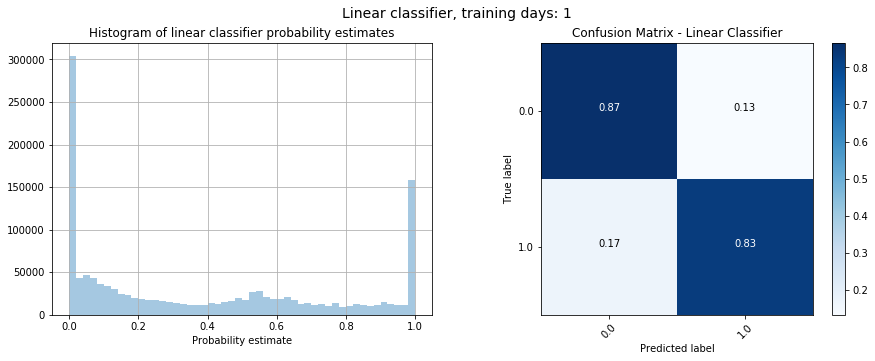

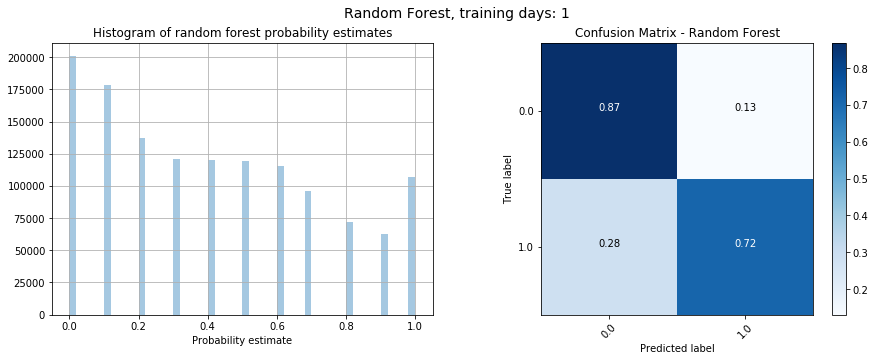

******************************************************************************************
******************************************************************************************


Evaluation, training days: 10, predicting days 3


Linear classifier accuracy: 83.54%


,Class,F1,Precision,Recall
0,0.0,0.865179,0.931873,0.807395
1,1.0,0.788886,0.709385,0.888455


Random forest accuracy: 81.84%


,Class,F1,Precision,Recall
0,0.0,0.866287,0.835194,0.899785
1,1.0,0.716856,0.778205,0.664472


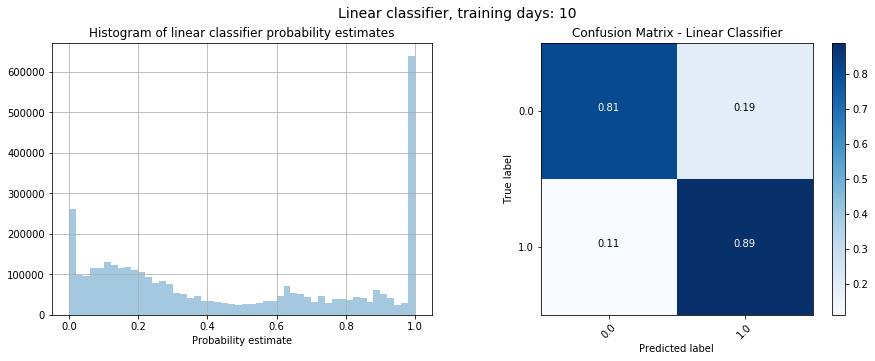

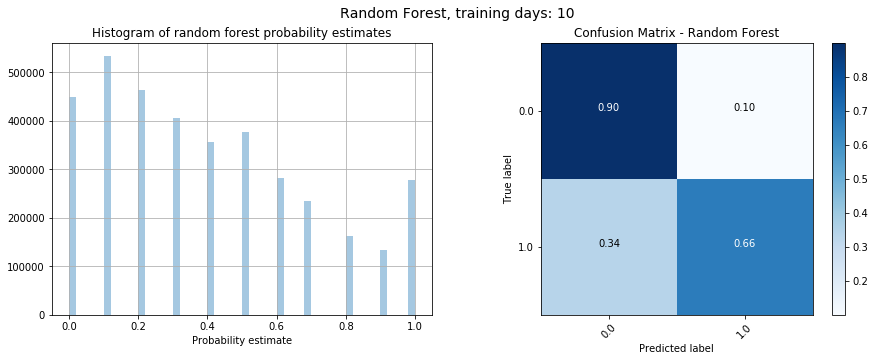

******************************************************************************************
******************************************************************************************


Evaluation, training days: 25, predicting days 3


Linear classifier accuracy: 86.06%


,Class,F1,Precision,Recall
0,0.0,0.888116,0.918538,0.859645
1,1.0,0.815009,0.772695,0.862225


Random forest accuracy: 81.66%


,Class,F1,Precision,Recall
0,0.0,0.858712,0.851869,0.865667
1,1.0,0.738782,0.749920,0.727970


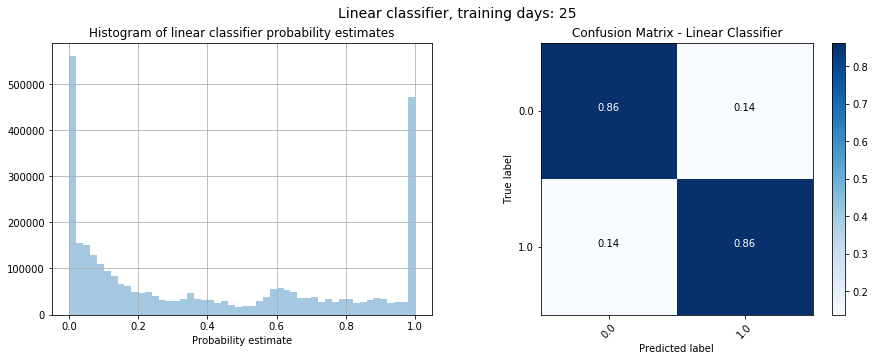

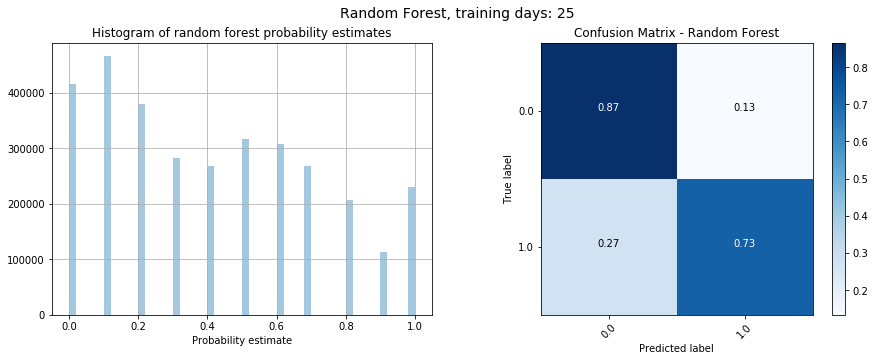

******************************************************************************************
******************************************************************************************




In [23]:
#Initialize lists which will become columns in a dataframe used for a history plot
linear_classifier_accuracy_scores = []
random_forest_accuracy_scores= []
days_of_training = []
#Iterate over training days
#Read the saved JSON of predictions and ground truth values from the test partition paired to it
for i in range(1, 28):
    with open('predictions/prediction_eval_training_days_%d.json' % i) as f:
        predictions_dict = json.loads(f.read())
        #Save the results in a dataframe
        df_eval = pd.DataFrame({'ground_truth': predictions_dict['ground_truth'],
                  'linear_classifier_predictions': predictions_dict['linear_classifier']['predictions'],
                  'linear_classifier_probabilities': predictions_dict['linear_classifier']['probabilities'],
                 'random_forest_predictions': predictions_dict['random_forest']['predictions'],
                 'random_forest_probabilities': predictions_dict['random_forest']['probabilities']})
    #Save the model accuracy at each day of training to plot a training curve
    days_of_training.append(i)
    linear_classifier_accuracy = (df_eval['ground_truth'] == df_eval['linear_classifier_predictions']).mean()
    linear_classifier_accuracy_scores.append(linear_classifier_accuracy)
    random_forest_accuracy = (df_eval['ground_truth'] == df_eval['random_forest_predictions']).mean()
    random_forest_accuracy_scores.append(random_forest_accuracy)
    #At arbitrary intervals, print/plot a multi-metric evaluation
    if i in [1, 10, 25]:
        print("Evaluation, training days: %d, predicting days %d" % (i, np.floor(len(df_eval['ground_truth']) / 1e6)))
        print("\n")
        print("Linear classifier accuracy: %.02f%%" % (linear_classifier_accuracy*100))
        evaluation_linear = modelFitEval(df_eval['ground_truth'], df_eval['linear_classifier_predictions'], "Confusion Matrix - Linear Classifier")
        display(evaluation_linear.metricsTable())
        print("Random forest accuracy: %.02f%%" % (random_forest_accuracy*100))
        evaluation_random_forest = modelFitEval(df_eval['ground_truth'], df_eval['random_forest_predictions'], "Confusion Matrix - Random Forest")
        display(evaluation_random_forest.metricsTable())
        
        #After printing some of the metrics, plot a confusion matrix and histogram of the probability estimates
        plt.subplots(1, 2, figsize=(15, 5))
        plt.suptitle("Linear classifier, training days: %d" % i, fontsize=14)
        plt.subplot(1, 2, 1)
        sns.distplot(df_eval['linear_classifier_probabilities'], kde=False)
        plt.grid()
        plt.xlabel("Probability estimate")
        plt.title('Histogram of linear classifier probability estimates')
        plt.subplot(1, 2, 2)
        evaluation_linear.plotConfMat()
        plt.show()
        
        plt.subplots(1, 2, figsize=(15, 5))
        plt.suptitle("Random Forest, training days: %d" % i, fontsize=14)
        plt.subplot(1, 2, 1)
        sns.distplot(df_eval['random_forest_probabilities'], kde=False)
        plt.grid()
        plt.xlabel("Probability estimate")
        plt.title('Histogram of random forest probability estimates')
        plt.subplot(1, 2, 2)
        evaluation_random_forest.plotConfMat()
        plt.show()

        print("*"*90)
        print("*"*90)
        print("\n")

### We observe that the random forest (although I didn't tune the hyperparameters) does not model the relationship between the targets and the predictors well.

### However, a linear classifier (optimizing the modified Huber loss with gradient descent and using $L_2$ regularization) quickly reaches a very nice fit with nearly 90% balanced accuracy, and continues to improve as it is fit to more days of training data.

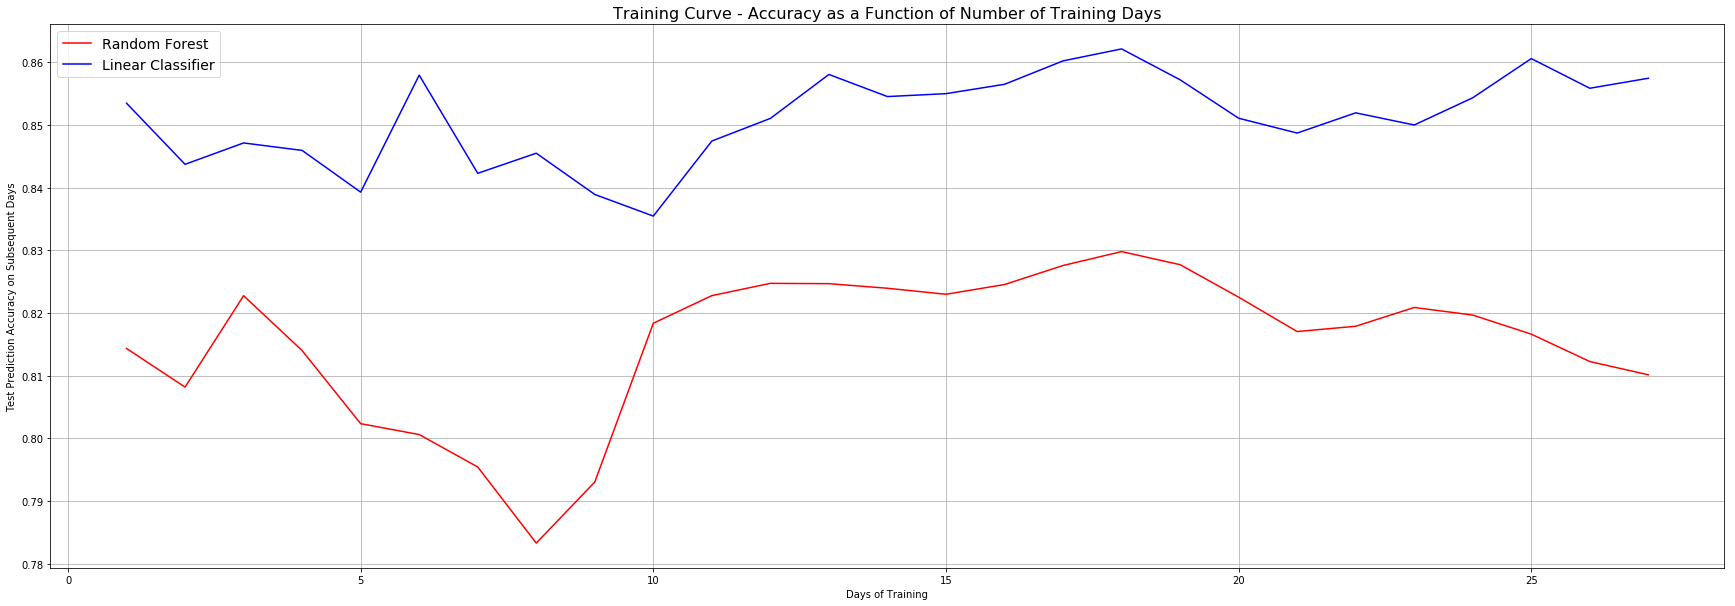

In [12]:
df_history = pd.DataFrame({"random_forest_accuracy": random_forest_accuracy_scores, 
                           "linear_classifier_accuracy": linear_classifier_accuracy_scores,
                           "days_of_training": days_of_training})
plt.figure(figsize=(30, 10))
plt.plot(df_history['days_of_training'], df_history['random_forest_accuracy'], color="red", label="Random Forest")
plt.plot(df_history['days_of_training'], df_history['linear_classifier_accuracy'], color="blue", label="Linear Classifier")
plt.xlabel("Days of Training", fontsize=14)
plt.ylabel("Test Prediction Accuracy on Subsequent Days", fontsize=14)
plt.title("Training Curve - Accuracy as a Function of Number of Training Days", fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.show()

## Further steps

### Hyperparameter tuning and model selection
#### If I'd had more time and some AWS credits for the project I would have used randomized search or some other method to tune the model hyperparameters. 
#### In my current job I use some very efficient methods to fit and tune different models (XGBoost or feed-forward neural nets, which I have written some modules to tune) with cross-validation to pick the best performing architecture and set of hyperparmeters for a particular dataset, generally on a large EC2 instance.
### Feature engineering
#### I would have liked to engineer some interesting numeric features for ad size: for example, the size of the advertisement in pixels (i.e., a 320x5 ad becomes 1600) and the shape of the ad (e.g, a 320x5 ad becomes 64 representing a wide banner ad).
#### However, I wasn't sure how to handle the frequent 'native' level in that column, so I stuck with my approach for this sample project. 

#### It could be interesting as well to leverage some human subject-matter expertise or perform more detailed analysis to engineer even stronger features.

### Improve knowledge of business objective

#### There are practically endless ways that we could spend time to try to incrementally improve the classification accuracy but the two above are the first that I would try. 

#### Other than that, I know that it is critical to keep the business objective in mind: which is more important in this case, recall or precision, and for which class? Is there a particular subset of the data where we are more concerned about classification accuracy or some other metric? Do we need a custom metric like the $F_\beta$ score? This needs to be considered before we decide how to improve.
